# AER621 Design Project Calculations - Michal Jagodzinski

This is a Jupyter Notebook containing the required calculations and analysis for the aerospace structural design final project. The contents of this Notebook are written in Python. This is not a substitute for the report but rather a proof-of-work and reference.

# Initialization

## Importing Python Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from skaero.atmosphere import coesa
import scipy.integrate as integrate
import scipy.interpolate as interpolate
from numba import njit

## Given Properties

In [2]:
# overall dimensions
ac_length = 28.0
ac_height = 9.2
fuselage_diameter = 3.5
wing_span = 31.0
wing_area = 90.0
wingbox_center_length = 3.5
wing_taper_ratio = 0.16
wing_sweep = 20 # degrees

# aircraft mass targets
max_takeoff = 48000
operating_empty = 21600
max_fuel = 14400
max_payload = 12000
max_cargo = 2880
wing_structure_sys = 4800
engine_mass = 1760 # per engine
total_gear_mass = 2400

# design airspeeds and aerodynamic info
cruise_speed = 0.80 # Ma
cruise_alt = 12000
max_design_speed = 0.85
max_lift_coeff = 1.5

# powerplant (two-wing mounted engines)
engine_thrust = 68000
engine_root_offset = 5

# fuel
fuel_wing = 6400 # total placed in each wing
fuel_wing_dist = 12 # 12 meters outward of wing root

# landing gear (two main)
main_lg_mass = 960
main_lg_offset = 2 # 2 m from wing root
nose_lg_mass = 480
nose_lg_offset = 4 # 4 m aft of aircraft nose

# wing structural mass
centrebox_mass = 800

# Part 1 - Landing Gear

## Sizing Calculations

### Oleo Strut Sizing

In [3]:
descent_velocity = 3.05
shock_efficiency = 0.7
tire_stroke = 0.03
reaction_factor = 2
num_struts = 2
num_tires = 2
landing_mass = max_takeoff - max_fuel

In [4]:
oleo_stroke = (descent_velocity**2)/(2*9.81*shock_efficiency*reaction_factor) - tire_stroke + 0.03

max_static_load = ((9.81*landing_mass)/num_struts)*0.224809 # converting to lbf
oleo_diameter = (0.041 + 0.0025*np.sqrt(max_static_load))*0.3048 # converting to m

oleo_length = 2.5*oleo_stroke

print('Stroke: ', oleo_stroke, ' m')
print('Diameter: ', oleo_diameter, ' m')
print('Length: ', oleo_length, ' m')

Stroke:  0.3386668122906654  m
Diameter:  0.15917006606071324  m
Length:  0.8466670307266635  m


### Tire Sizing

In [5]:
weight_wheel = ((landing_mass)/num_struts)/num_tires
A_coeff = 5.1
B_coeff = 0.349

wheel_diameter = A_coeff * np.power(weight_wheel, B_coeff)

print('Main wheel diameter: ', wheel_diameter, ' cm')
print('Main wheel diameter: ', wheel_diameter*0.393701, ' in')

Main wheel diameter:  119.43830924387257  cm
Main wheel diameter:  47.02298178762187  in


Based on wheel diameter, Type VIII 47$\times$18-18 wheels are chosen

## Material Selection and Analysis

In [6]:
# from CATIA model
lg_housing_vol = 0.009678
lg_piston_vol = 0.01708
total_vol = lg_housing_vol + lg_piston_vol

In [7]:
# data from http://ijiset.com/vol4/v4s4/IJISET_V4_I04_34.pdf
# dictionary scheme: 'material name': [density kg/m^3, yield strength MPa]
materials = {
    'Aluminum Alloy 7075': [2.88e3, 95],
    'Steel Alloy 4340': [7.7e3, 472.3],
    'Titanium 6AL-4V': [4.43e3, 880],
    'Titanium 6AL-6V-2Sn': [4.54e3, 980],
    'Titanium 10Al-2Fe-3V': [4.65e3, 1050]
}

In [8]:
housing_mass = [lg_housing_vol * materials[key][0] for key in materials]
piston_mass = [lg_piston_vol * materials[key][0] for key in materials]

mat_data = {
    'Material': [key for key in materials], 
    'Housing Mass [kg]': housing_mass, 
    'Piston Mass [kg]': piston_mass,
    'Yield Strength [MPa]': [materials[key][1] for key in materials]
}
results = pd.DataFrame(data=mat_data).set_index('Material')

results

,Housing Mass [kg],Piston Mass [kg],Yield Strength [MPa]
Material,,,
Aluminum Alloy 7075,27.87264,49.1904,95.0
Steel Alloy 4340,74.52060,131.5160,472.3
Titanium 6AL-4V,42.87354,75.6644,880.0
Titanium 6AL-6V-2Sn,43.93812,77.5432,980.0
Titanium 10Al-2Fe-3V,45.00270,79.4220,1050.0


In [9]:
# comparing configurations wrt mass
mass_config = [[mass + mass2 for mass2 in piston_mass] for mass in housing_mass]
configurations_mass = pd.DataFrame(data=mass_config, columns=[key for key in materials])
configurations_mass.insert(0, 'Housing/Piston', [key for key in materials])

configurations_mass = configurations_mass.set_index('Housing/Piston')

configurations_mass

,Aluminum Alloy 7075,Steel Alloy 4340,Titanium 6AL-4V,Titanium 6AL-6V-2Sn,Titanium 10Al-2Fe-3V
Housing/Piston,,,,,
Aluminum Alloy 7075,77.06304,159.38864,103.53704,105.41584,107.29464
Steel Alloy 4340,123.71100,206.03660,150.18500,152.06380,153.94260
Titanium 6AL-4V,92.06394,174.38954,118.53794,120.41674,122.29554
Titanium 6AL-6V-2Sn,93.12852,175.45412,119.60252,121.48132,123.36012
Titanium 10Al-2Fe-3V,94.19310,176.51870,120.66710,122.54590,124.42470


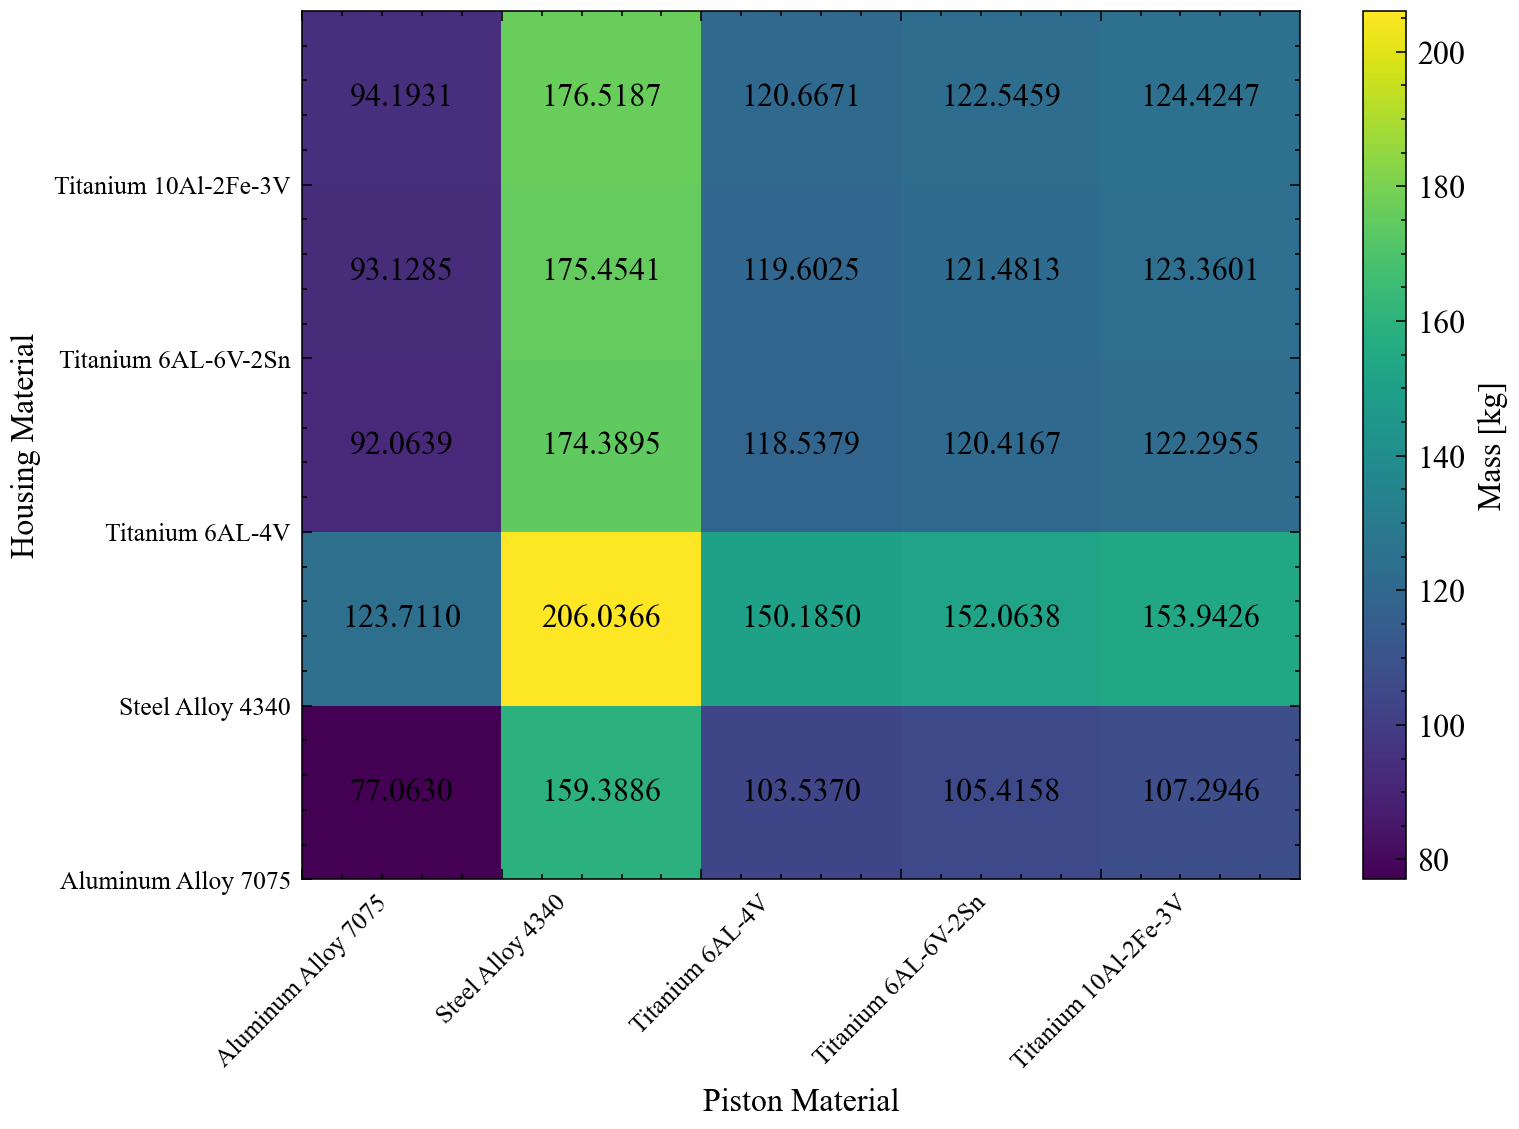

In [10]:
plt.figure(dpi=230, figsize=(7,5))
plt.style.use(['science', 'no-latex'])

mass_config = np.array(mass_config)

plt.pcolor(mass_config)

mat_labels = [key for key in materials]
plt.xticks(range(len(mat_labels)), mat_labels, rotation=45, size=8)
plt.yticks(range(len(mat_labels)), mat_labels, size=8)

plt.xlabel('Piston Material')
plt.ylabel('Housing Material')

for y in range(mass_config.shape[0]):
    for x in range(mass_config.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.4f' % mass_config[y, x], horizontalalignment='center', verticalalignment='center')

plt.colorbar(label='Mass [kg]')
plt.show()

In [11]:
# comparing configurations wrt strength
housing_strength = [(lg_housing_vol / total_vol) * materials[key][1] for key in materials]
piston_strength = [(lg_piston_vol / total_vol) * materials[key][1] for key in materials]

strength_config = [[s + s2 for s2 in housing_strength] for s in piston_strength]

configurations_strength = pd.DataFrame(data=strength_config, columns=[key for key in materials])
configurations_strength.insert(0, 'Housing/Piston', [key for key in materials])

configurations_strength = configurations_strength.set_index('Housing/Piston')

configurations_strength

,Aluminum Alloy 7075,Steel Alloy 4340,Titanium 6AL-4V,Titanium 6AL-6V-2Sn,Titanium 10Al-2Fe-3V
Housing/Piston,,,,,
Aluminum Alloy 7075,95.000000,231.464213,378.923686,415.092309,440.410345
Steel Alloy 4340,335.835787,472.300000,619.759474,655.928096,681.246132
Titanium 6AL-4V,596.076314,732.540526,880.000000,916.168622,941.486658
Titanium 6AL-6V-2Sn,659.907691,796.371904,943.831378,980.000000,1005.318036
Titanium 10Al-2Fe-3V,704.589655,841.053868,988.513342,1024.681964,1050.000000


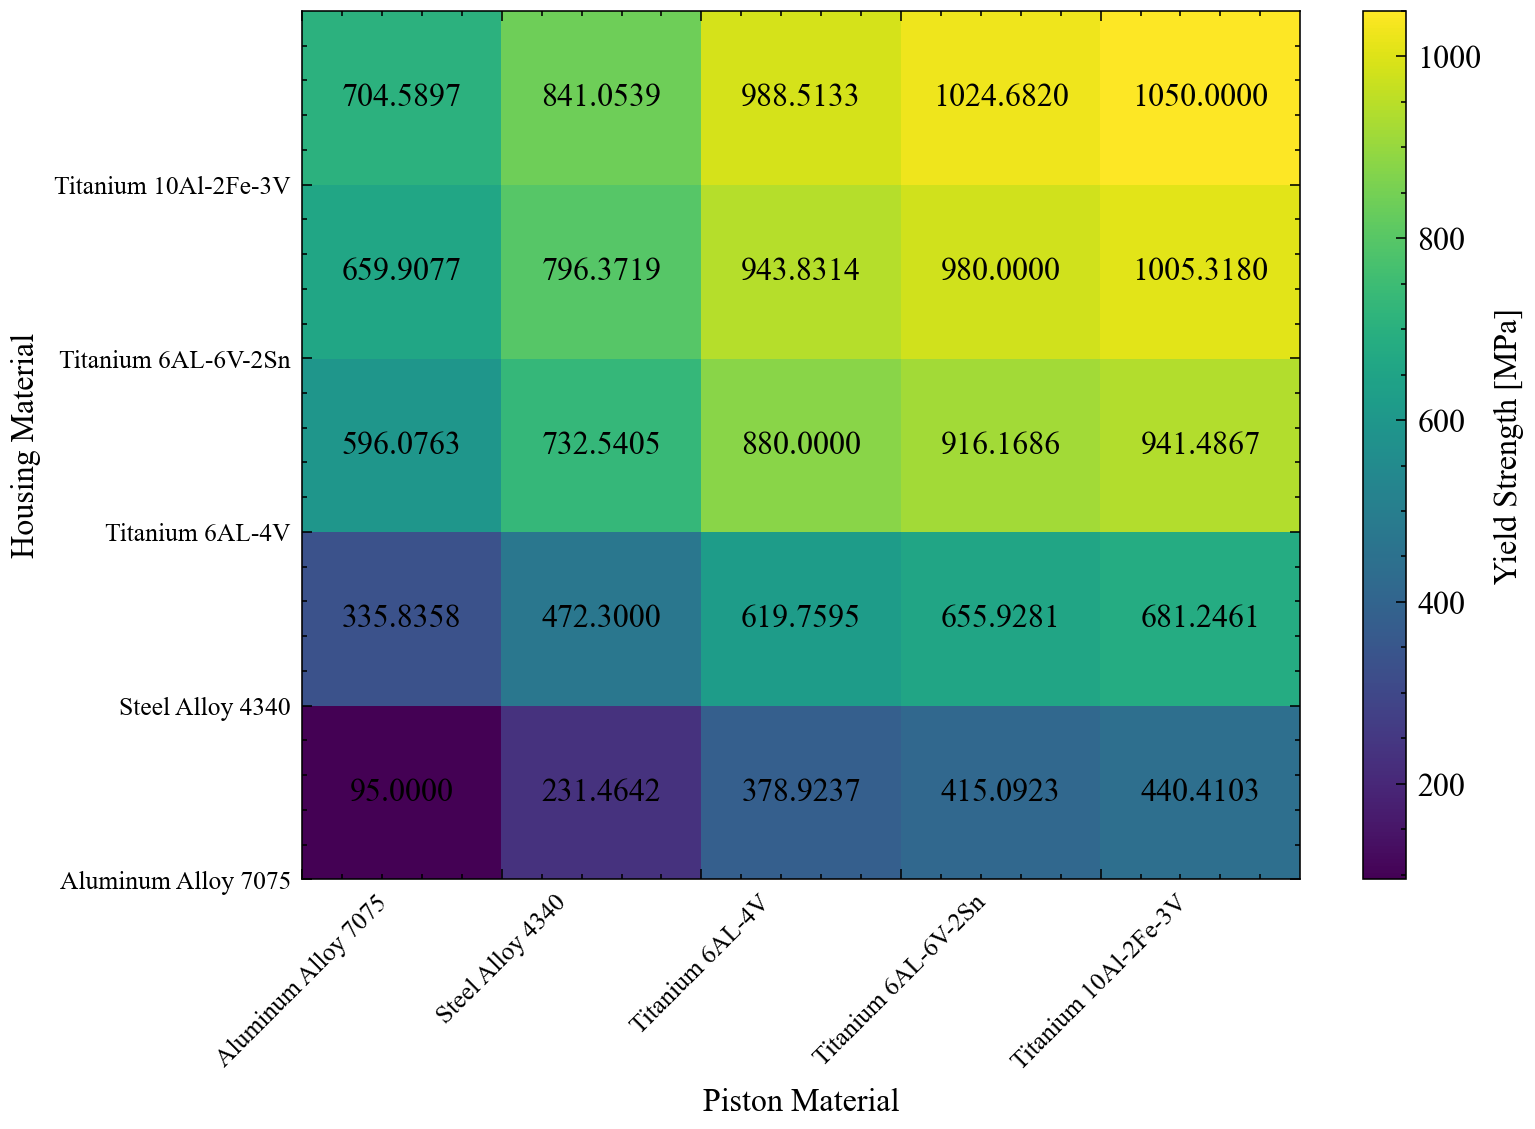

In [12]:
plt.figure(dpi=230, figsize=(7,5))
plt.style.use(['science', 'no-latex'])

strength_config = np.array(strength_config)

plt.pcolor(strength_config)

mat_labels = [key for key in materials]
plt.xticks(range(len(mat_labels)), mat_labels, rotation=45, size=8)
plt.yticks(range(len(mat_labels)), mat_labels, size=8)

plt.xlabel('Piston Material')
plt.ylabel('Housing Material')

for y in range(strength_config.shape[0]):
    for x in range(strength_config.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.4f' % strength_config[y, x], horizontalalignment='center', verticalalignment='center')

plt.colorbar(label='Yield Strength [MPa]')
plt.show()

In [13]:
# comparing configurations wrt strength to mass ratio
ratios = strength_config/mass_config

configurations_ratios = pd.DataFrame(data=ratios, columns=[key for key in materials])
configurations_ratios.insert(0, 'Housing/Piston', [key for key in materials])

configurations_ratios = configurations_ratios.set_index('Housing/Piston')

configurations_ratios

,Aluminum Alloy 7075,Steel Alloy 4340,Titanium 6AL-4V,Titanium 6AL-6V-2Sn,Titanium 10Al-2Fe-3V
Housing/Piston,,,,,
Aluminum Alloy 7075,1.232757,1.452200,3.659789,3.937665,4.104682
Steel Alloy 4340,2.714680,2.292311,4.126640,4.313506,4.425326
Titanium 6AL-4V,6.474591,4.200599,7.423783,7.608316,7.698455
Titanium 6AL-6V-2Sn,7.085989,4.538918,7.891400,8.067084,8.149457
Titanium 10Al-2Fe-3V,7.480268,4.764673,8.192070,8.361618,8.438839


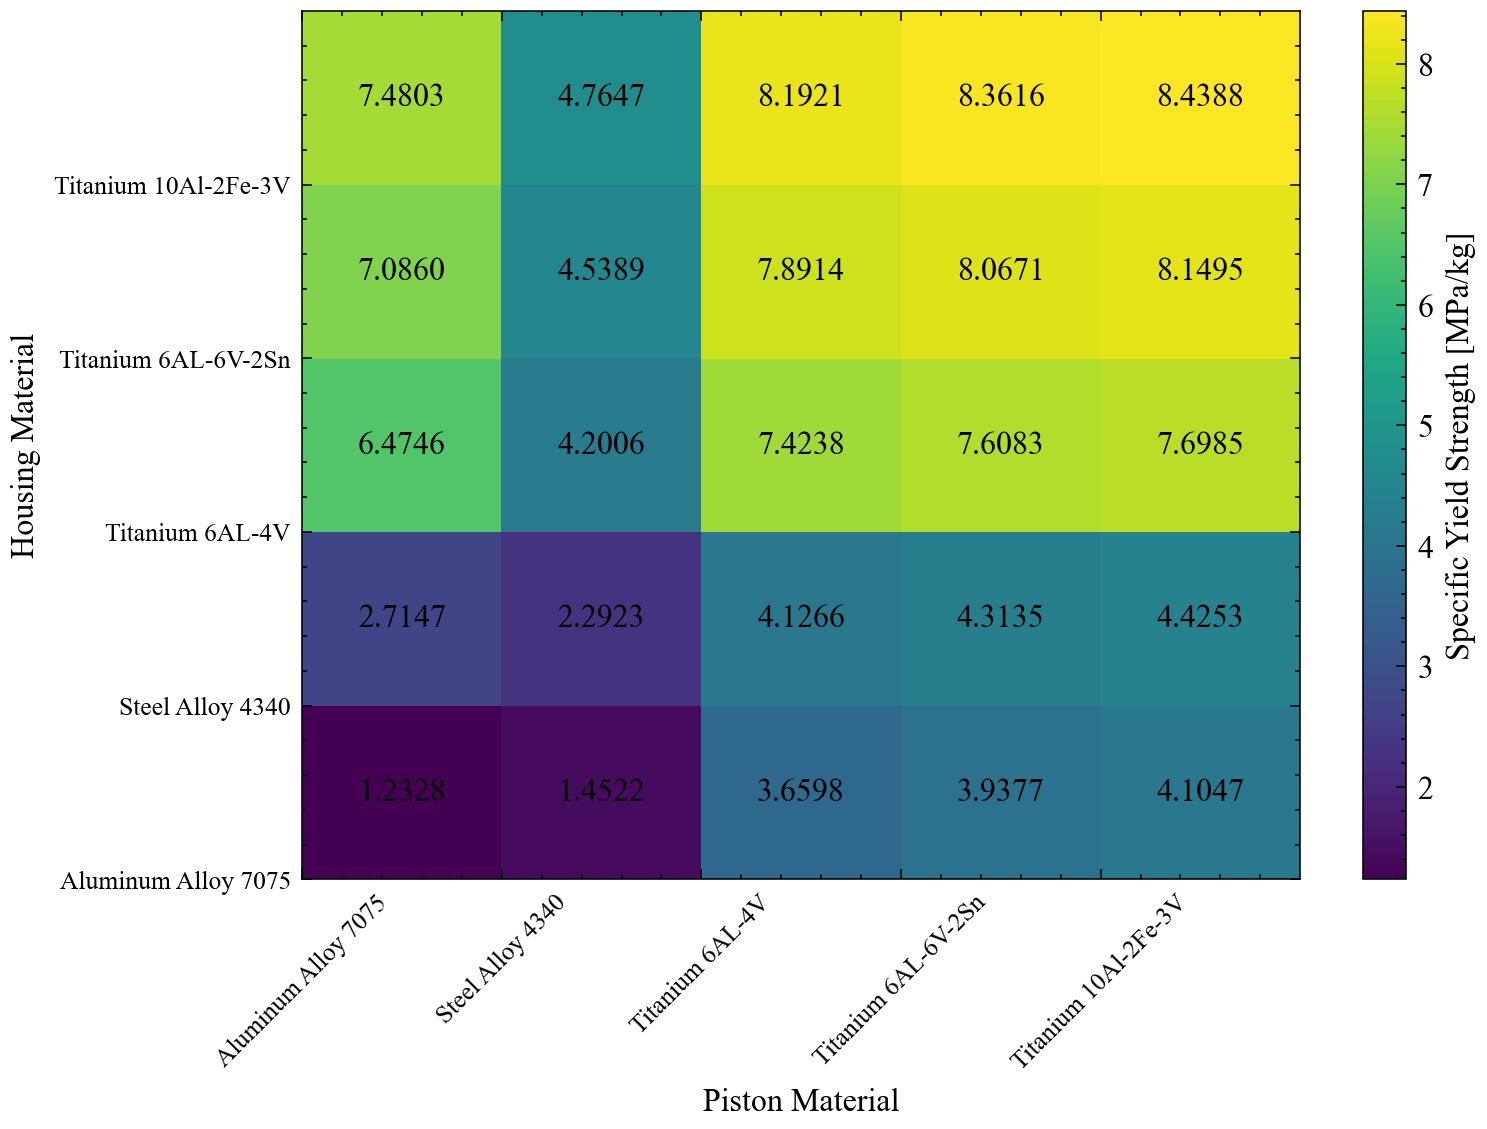

In [14]:
plt.figure(dpi=230, figsize=(7,5))
plt.style.use(['science', 'no-latex'])

plt.pcolor(ratios)

plt.xticks(range(len(mat_labels)), mat_labels, rotation=45, size=8)
plt.yticks(range(len(mat_labels)), mat_labels, size=8)

plt.xlabel('Piston Material')
plt.ylabel('Housing Material')

for y in range(ratios.shape[0]):
    for x in range(ratios.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.4f' % ratios[y, x], horizontalalignment='center', verticalalignment='center')

plt.colorbar(label='Specific Yield Strength [MPa/kg]')
plt.show()

# Part 2 - Wing Box

## Flight Envelope

In [15]:
# given properties
cruise_mach = 0.80
cruise_alt = 12000

max_mach = 0.85
max_cl = 1.5

num_engines = 2
mass_engines = 1760
thrust = 68e3 # per engine

sl_density = 1.225

In [16]:
# calculations needed for flight envelope
# properties at 12,000 m
alt_temperature = coesa.table(cruise_alt)[1]
alt_density = coesa.table(cruise_alt)[3]

# equivalent velocities
eq_cruise_vel = np.sqrt(alt_density/sl_density) * cruise_mach * np.sqrt(1.4 * 287 * alt_temperature)
eq_max_vel = np.sqrt(alt_density/sl_density) * max_mach * np.sqrt(1.4 * 287 * alt_temperature)

n_lim = 2.1 + 24000/(max_takeoff*2.20462 + 10000)

eq_cruise_vel, eq_max_vel, n_lim

(118.8957378714541, 126.32672148841996, 2.307214948210077)

In [17]:
alt_density/sl_density, alt_temperature

(0.2537371007278479, 216.64999999999998)

In [18]:
# creating stall curve vectors
n_vec_pos = np.linspace(0, n_lim)
n_vec_neg = np.linspace(0, -1)

def velocity(n):
    return np.sqrt((2 * abs(n) * (max_takeoff * 9.81)) / (sl_density * wing_area * max_cl))

vel_pos = velocity(n_vec_pos)
vel_neg = velocity(n_vec_neg)

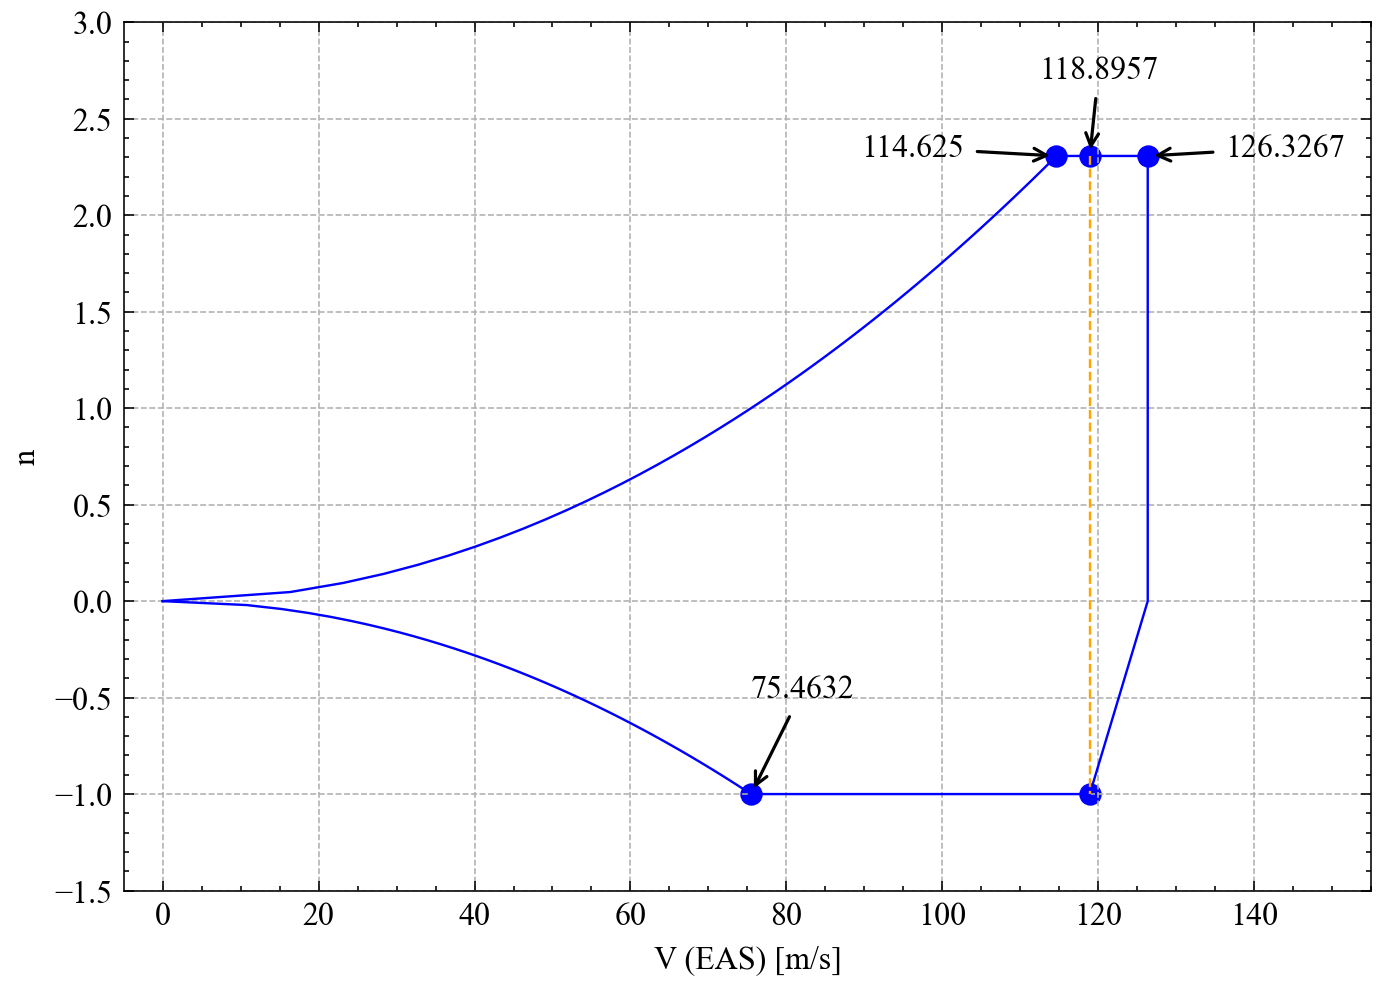

In [19]:
# plotting flight envelope
plt.figure(dpi=230, figsize=(7,5))
plt.style.use(['science', 'no-latex'])

# plotting stall curves
plt.plot(vel_pos, n_vec_pos, color='b', linewidth=0.75)
plt.plot(vel_neg, n_vec_neg, color='b', linewidth=0.75)

# plotting and annotating definite points
plt.scatter(eq_cruise_vel, n_lim, color='b')
plt.annotate(
    str(np.round(eq_cruise_vel, decimals=4)), 
    xy = (eq_cruise_vel, n_lim), xycoords='data',
    xytext=(eq_cruise_vel-6.5, n_lim+0.4), textcoords='data',
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
)

plt.scatter(eq_max_vel, n_lim, color='b')
plt.annotate(
    str(np.round(eq_max_vel, decimals=4)), 
    xy = (eq_max_vel, n_lim), xycoords='data',
    xytext=(eq_max_vel+10, n_lim), textcoords='data',
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
)

plt.scatter(vel_pos[-1], n_lim, color='b')
plt.annotate(
    str(np.round(vel_pos[-1], decimals=4)), 
    xy = (vel_pos[-1], n_lim), xycoords='data',
    xytext=(vel_pos[-1]-25, n_lim), textcoords='data',
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
)

plt.scatter(vel_neg[-1], -1, color='b')
plt.annotate(
    str(np.round(vel_neg[-1], decimals=4)), 
    xy = (vel_neg[-1], -1), xycoords='data',
    xytext=(vel_neg[-1], -0.5), textcoords='data',
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
)

plt.scatter(eq_cruise_vel, -1, color='b')

# connecting points together
plt.plot([vel_pos[-1], eq_max_vel, eq_max_vel, eq_cruise_vel, vel_neg[-1]], [n_lim, n_lim, 0, -1, -1], color='b', linewidth=0.75)
plt.plot([eq_cruise_vel, eq_cruise_vel], [n_lim, -1], linestyle='--', color='orange', linewidth=0.75)

plt.xlabel('V (EAS) [m/s]')
plt.ylabel('n')

plt.grid(linestyle='--')
plt.ylim([-1.5, 3])
plt.xlim([-5, 155])

plt.show()

## Wing Box Design

In [20]:
# determining load at PHAA and bending moment
phaa_load = 0.5 * sl_density * np.power(vel_pos[-1], 2) * wing_area * max_cl
root_bending_moment = 1.5 * (phaa_load / 2) * ((wing_span - fuselage_diameter) / 3)
phaa_load, root_bending_moment, wing_span - fuselage_diameter

(1086421.3748131609, 7469146.951840481, 27.5)

### Iteration 1

In [21]:
# finding bending stress of first iteration wing box
stringer_area = 0.0003 # 300 mm^2
skin_thickness = 0.003 # 3 mm

box_length = 3.5
box_height = 1
stringer_space = 3.5/16

boom_list = np.zeros(16)

boom_list[0] = stringer_area + (stringer_space * skin_thickness / 6) + 3*(stringer_space * skin_thickness / 6)
boom_list[7] = boom_list[8] = boom_list[15] = boom_list[0]

boom_list[1] = stringer_area + 6*(stringer_space * skin_thickness / 6)
boom_list[2:7] = boom_list[9:15]  = boom_list[1]

# I_xx = sum B_i y_i^2
Ixx = 4*boom_list[0] * 0.25 + 12*boom_list[1]*0.25

bending_stress = 0.5 * root_bending_moment / Ixx

print('Bending stress: ', np.round(bending_stress/1e6, decimals=4), ' MPa')

# finding critical buckling stress of first iteration wing box

# young's mod for 3k unidirectional carbon fiber composite: 
#    https://www.researchgate.net/publication/267548587_Recent_Advances_in_Inorganic_Polymer_Composites

# poisson's ratio for standard carbon fiber unidirectional:
#    http://www.performance-composites.com/carbonfibre/mechanicalproperties_2.asp

youngs_mod = 84.95e9
poisson_ratio = 0.30
ab_ratio = 1 / stringer_space
kc = 8

stress_critical = ((kc * np.power(np.pi, 2) * youngs_mod)/(12*(1 - np.power(poisson_ratio, 2)))) * np.power(skin_thickness/stringer_space, 2)

print('Critical stress: ', np.round(stress_critical/1e6, decimals=4), ' MPa')

print('Bending stress less than critical stress?', bending_stress < stress_critical)

Bending stress:  1035.5836  MPa
Critical stress:  115.5252  MPa
Bending stress less than critical stress? False


### Design Space

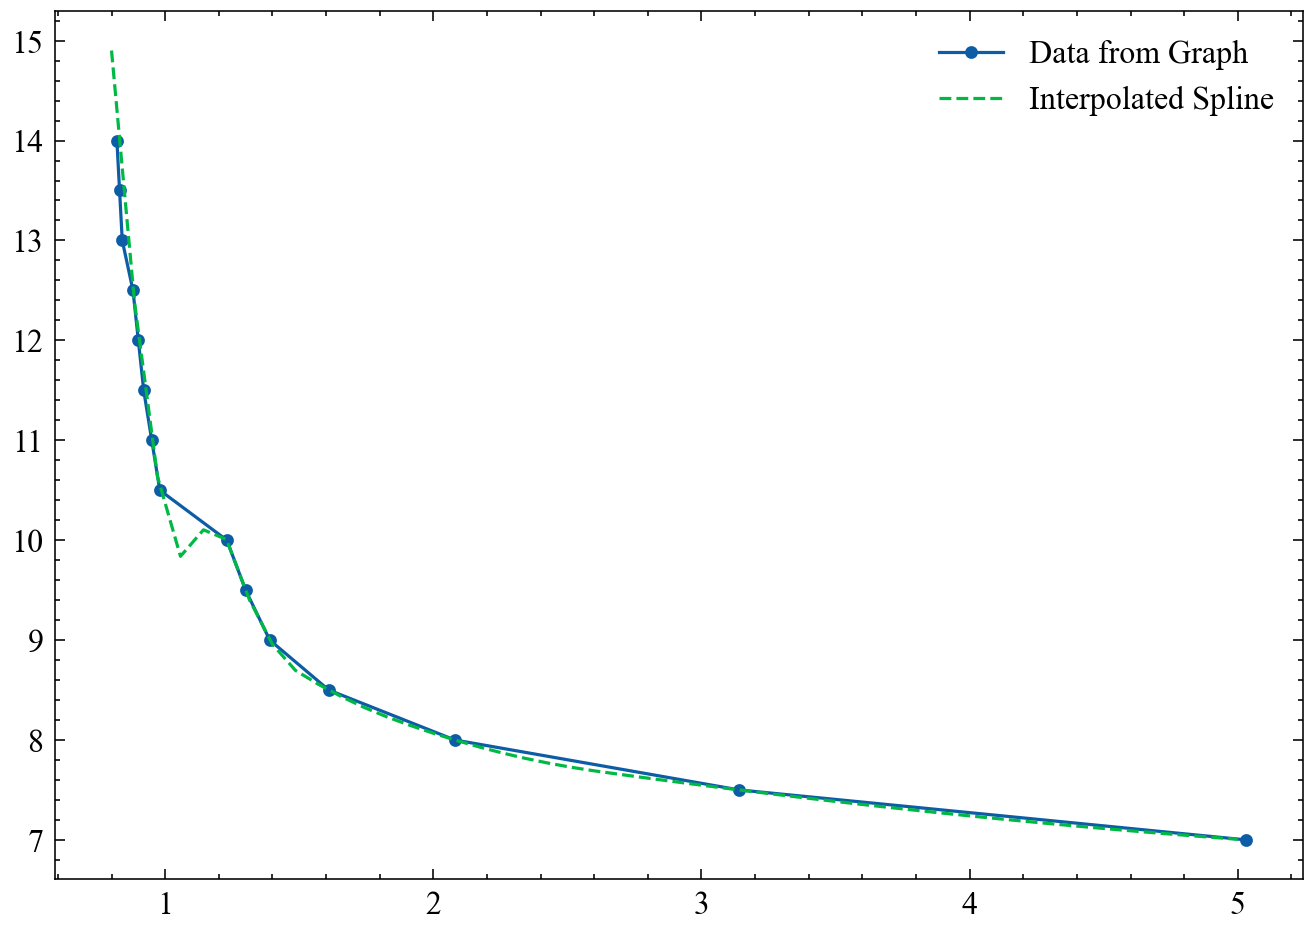

In [22]:
# function for approximating buckling constant
x_k = np.array([0.82, 0.83, 0.84, 0.88, 0.90, 0.92, 0.95, 0.98, 1.23, 1.30, 1.39, 1.61, 2.08, 3.14, 5.03])
y_k = np.array([14.0, 13.5, 13.0, 12.5, 12.0, 11.5, 11.0, 10.5, 10.0, 9.5, 9.0, 8.5, 8.0, 7.5, 7.0])

buckling_interp = interpolate.InterpolatedUnivariateSpline(x_k, y_k, k=2)
x_vec_buckling = np.linspace(0.8, 5)

plt.figure(dpi=230, figsize=(7,5))
plt.style.use(['science', 'no-latex'])

plt.plot(x_k, y_k, marker='.', label='Data from Graph')
plt.plot(x_vec_buckling, buckling_interp(x_vec_buckling), linestyle='--', label='Interpolated Spline')

plt.legend()
plt.show()

#### Stress Analysis

In [23]:
# calculates the difference between the bending and critical stresses
# positive value => valid design, negative value => invalid design

def stress_difference(stringer_area, skin_thickness, num_booms=16):
    arr = []
    
    for area in stringer_area:
        arrl = []
        for thickness in skin_thickness:
            stringer_space = box_length / (num_booms/2)

            num_big = 4
            num_small = num_booms - num_big
            num_small_row = num_small / 2

            boom_corner = area + (stringer_space * thickness / 6) + 3*(stringer_space * thickness / 6)
            boom_mid = area + 6*(stringer_space * thickness / 6)

            Ixx = num_big*boom_corner*0.25 + num_small*boom_mid*0.25

            bending_stress = 0.5 * root_bending_moment / Ixx

            ab_ratio = 1 / stringer_space
            kc = buckling_interp(ab_ratio)
            
            critical_stress = ((kc * np.power(np.pi, 2) * youngs_mod)/(12*(1 - np.power(poisson_ratio, 2)))) * np.power(thickness/stringer_space, 2)

            arrl.append((critical_stress - bending_stress)/1e6)

        arr.append(arrl)

    return np.array(arr)

In [24]:
# design space for 16 booms
num_points = 500

area_lims = [0.0006, 0.0012]
thickness_lims = [0.006, 0.012]

stringer_area_vec = np.linspace(area_lims[0], area_lims[1], num=num_points)
skin_thickness_vec = np.linspace(thickness_lims[0], thickness_lims[1], num=num_points)

stress_differences = stress_difference(stringer_area_vec, skin_thickness_vec)

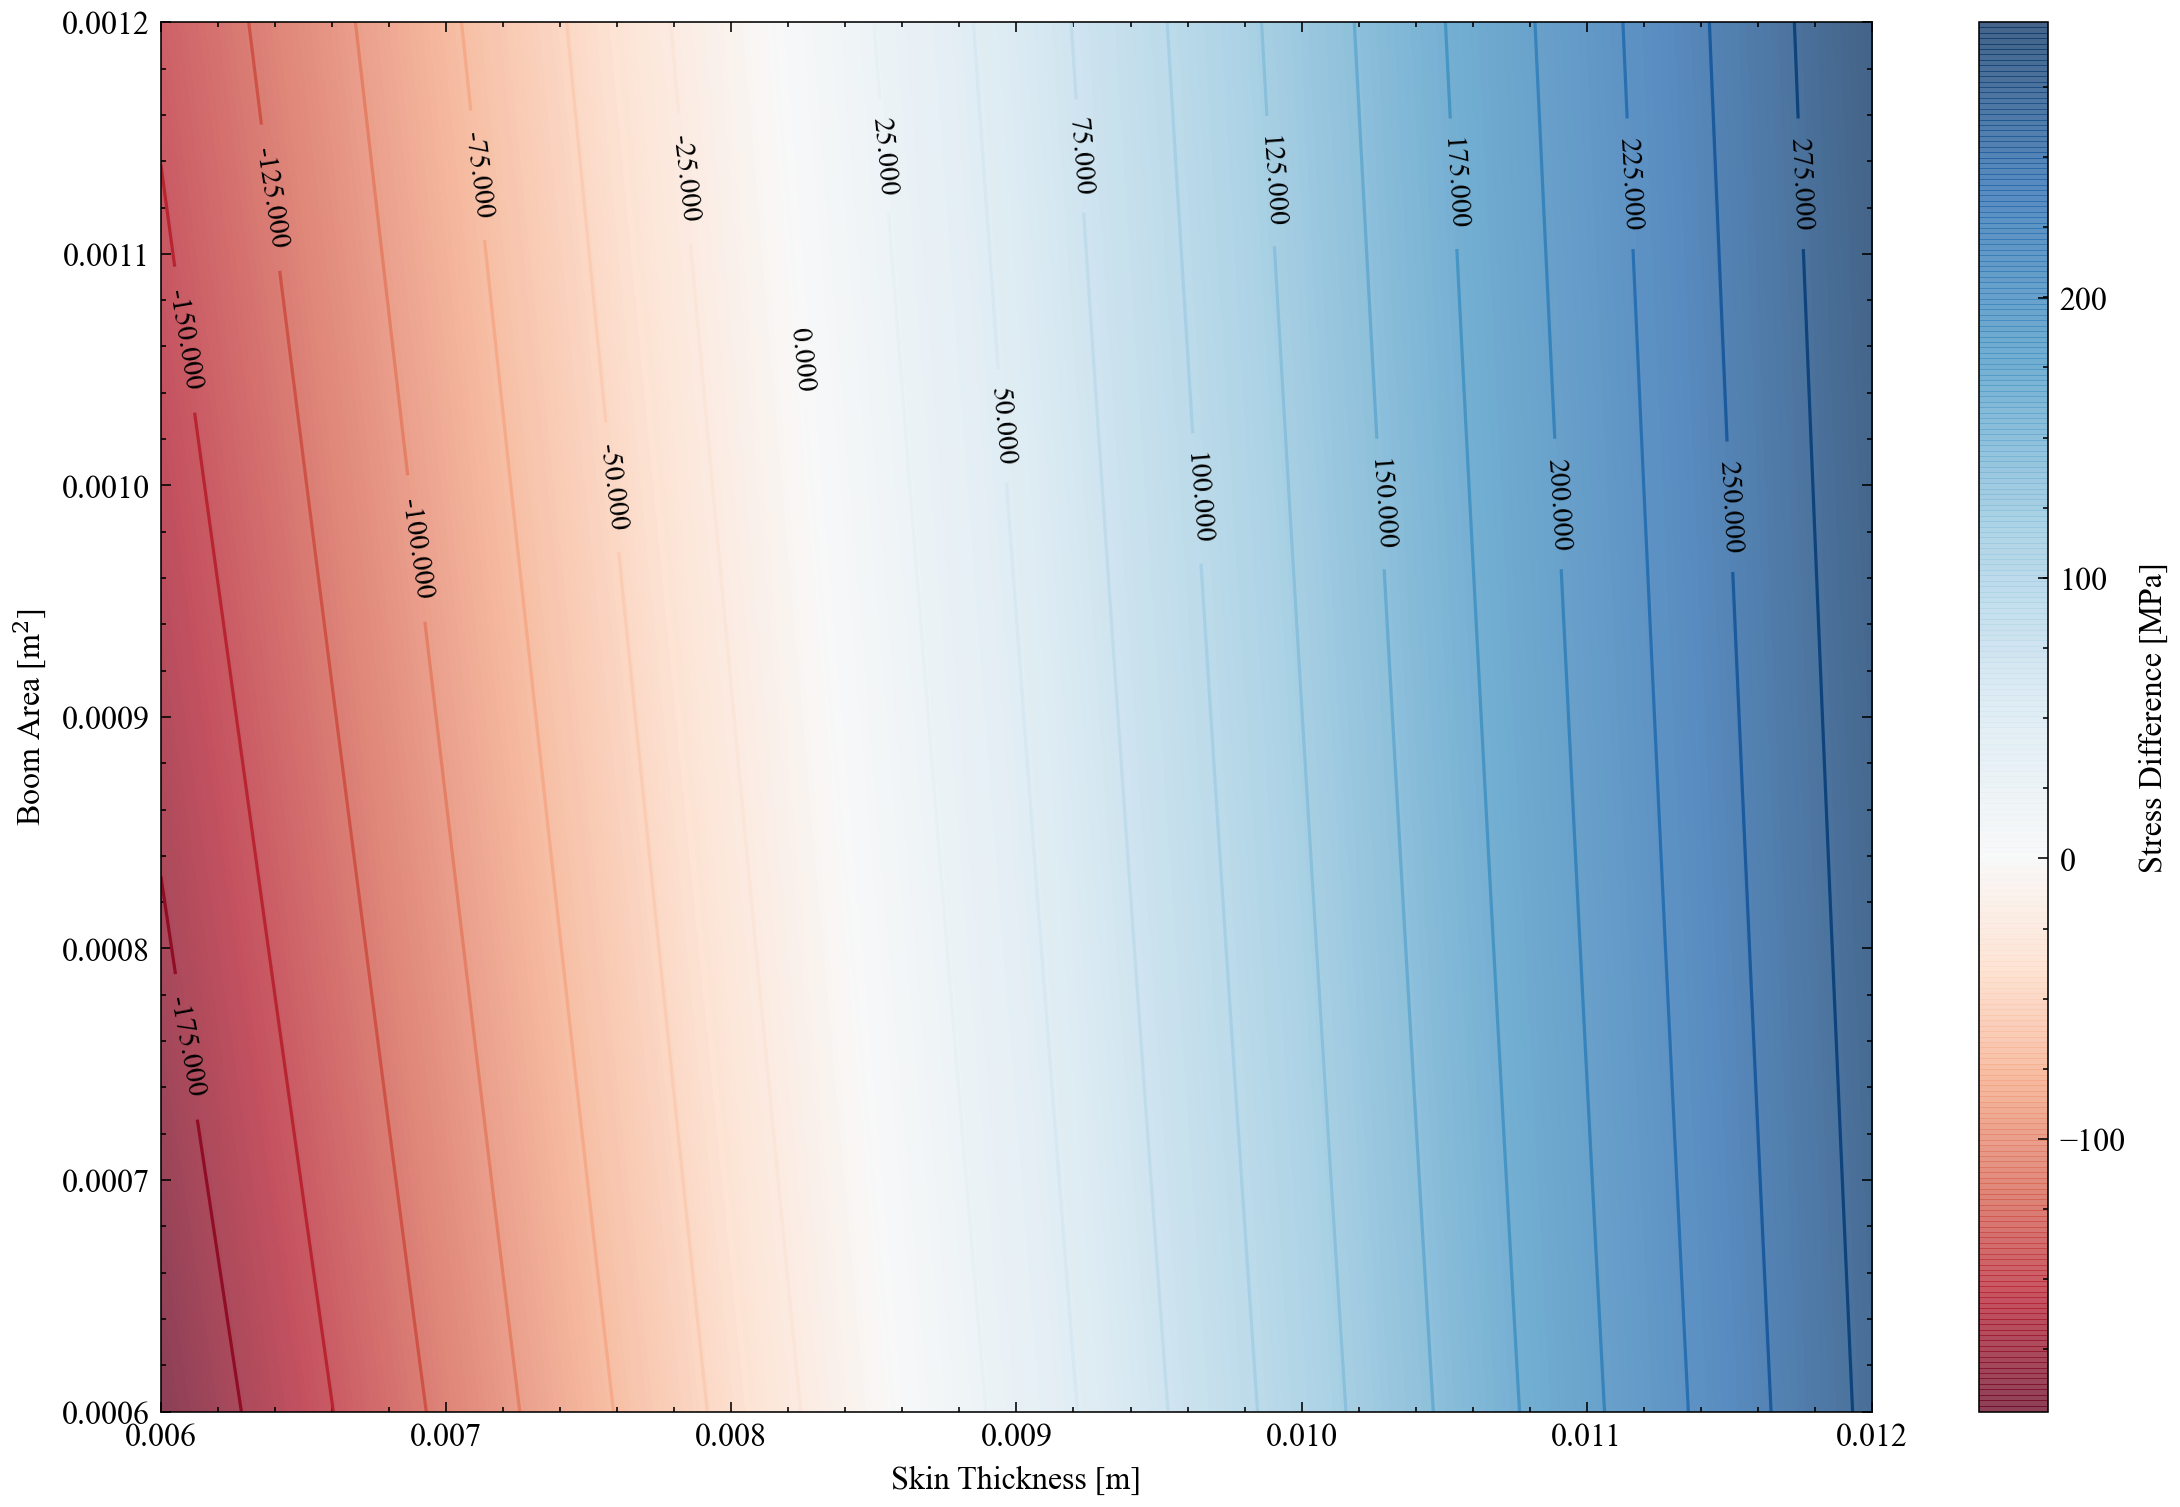

In [25]:
plt.figure(dpi=230, figsize=(12,8))
plt.style.use(['science', 'no-latex'])

colormap = plt.cm.RdBu
normalize = matplotlib.colors.TwoSlopeNorm(vmin=stress_differences[0][0], vcenter=0, vmax=stress_differences[-1][-1])

x_mesh, y_mesh = np.meshgrid(skin_thickness_vec, stringer_area_vec)

contours = plt.contour(x_mesh, y_mesh, stress_differences, 20, cmap=colormap, norm=normalize)

plt.clabel(contours, inline=True, fontsize=9, colors='black')

plt.imshow(
    stress_differences,
    extent = [thickness_lims[0], thickness_lims[1], area_lims[0], area_lims[1]], 
    origin='lower', 
    alpha=0.75, 
    aspect='auto', 
    cmap=colormap,
    norm=normalize
)

plt.ylabel(r'Boom Area [m$^2$]')
plt.xlabel(r'Skin Thickness [m]')

plt.colorbar(label='Stress Difference [MPa]')

plt.show()

#### Weight Analysis

In [26]:
# chosen material is 3k unidirectional CF, properties from link above
cf_density = 1.87*1e3
box_length = 3.5
box_height = 1
box_width = 1 # box extends from 6-7 m from the wing root

def box_mass(stringer_area, skin_thickness, num_booms=16):
    arr = []
    
    for area in stringer_area:
        arrl = []
        for thickness in skin_thickness:
            area_booms = num_booms * area
            area_skin = (2*box_length + 2*box_height) * thickness
            
            total_area = area_booms + area_skin
            total_volume = total_area * box_width
            total_mass = total_volume * cf_density

            arrl.append(total_mass)

        arr.append(arrl)

    return np.array(arr)

In [27]:
box_masses = box_mass(stringer_area_vec, skin_thickness_vec)

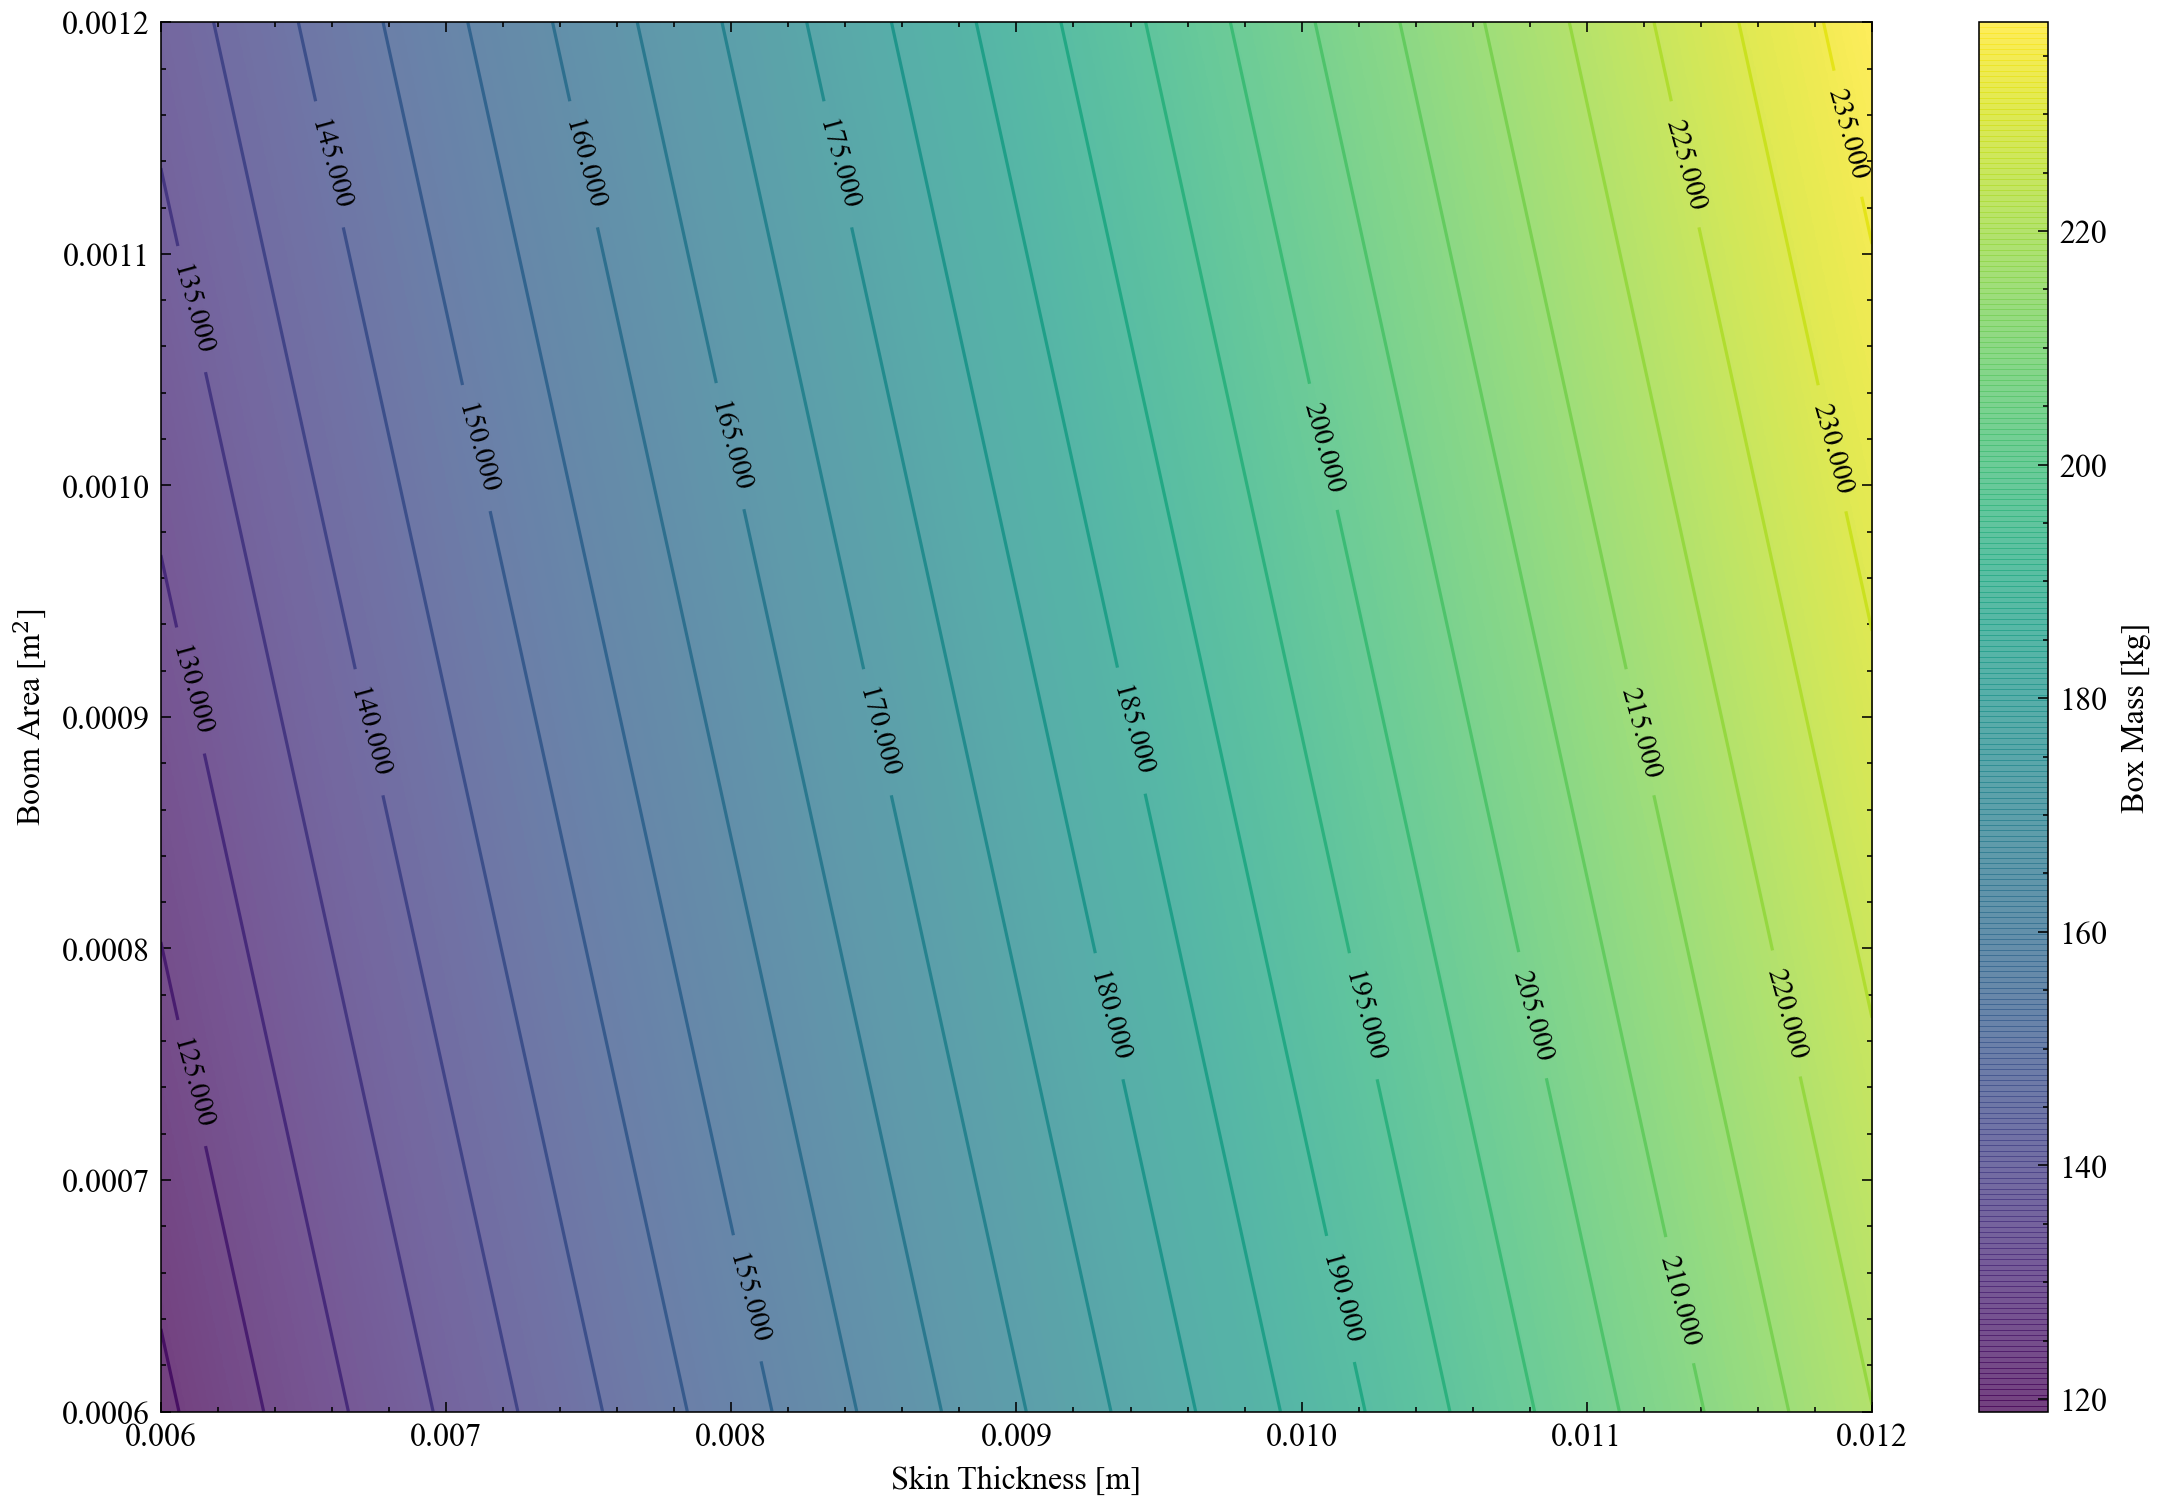

In [28]:
plt.figure(dpi=230, figsize=(12,8))
plt.style.use(['science', 'no-latex'])

x_mesh, y_mesh = np.meshgrid(skin_thickness_vec, stringer_area_vec)

contours = plt.contour(x_mesh, y_mesh, box_masses, 25)

plt.clabel(contours, inline=True, fontsize=9, colors='black')

plt.imshow(
    box_masses,
    extent = [thickness_lims[0], thickness_lims[1], area_lims[0], area_lims[1]], 
    origin='lower', 
    alpha=0.75, 
    aspect='auto'
)

plt.ylabel(r'Boom Area [m$^2$]')
plt.xlabel(r'Skin Thickness [m]')

plt.colorbar(label='Box Mass [kg]')

plt.show()

In [29]:
def crit_stress(stringer_area, skin_thickness, num_booms=16):
    arr = []
    
    for area in stringer_area:
        arrl = []
        for thickness in skin_thickness:
            stringer_space = box_length / (num_booms/2)

            ab_ratio = 1 / stringer_space
            kc = buckling_interp(ab_ratio)
            
            critical_stress = ((kc * np.power(np.pi, 2) * youngs_mod)/(12*(1 - np.power(poisson_ratio, 2)))) * np.power(thickness/stringer_space, 2)

            arrl.append(critical_stress/1e6)

        arr.append(arrl)

    return np.array(arr)

In [30]:
critical_stresses = crit_stress(skin_thickness_vec, stringer_area_vec)

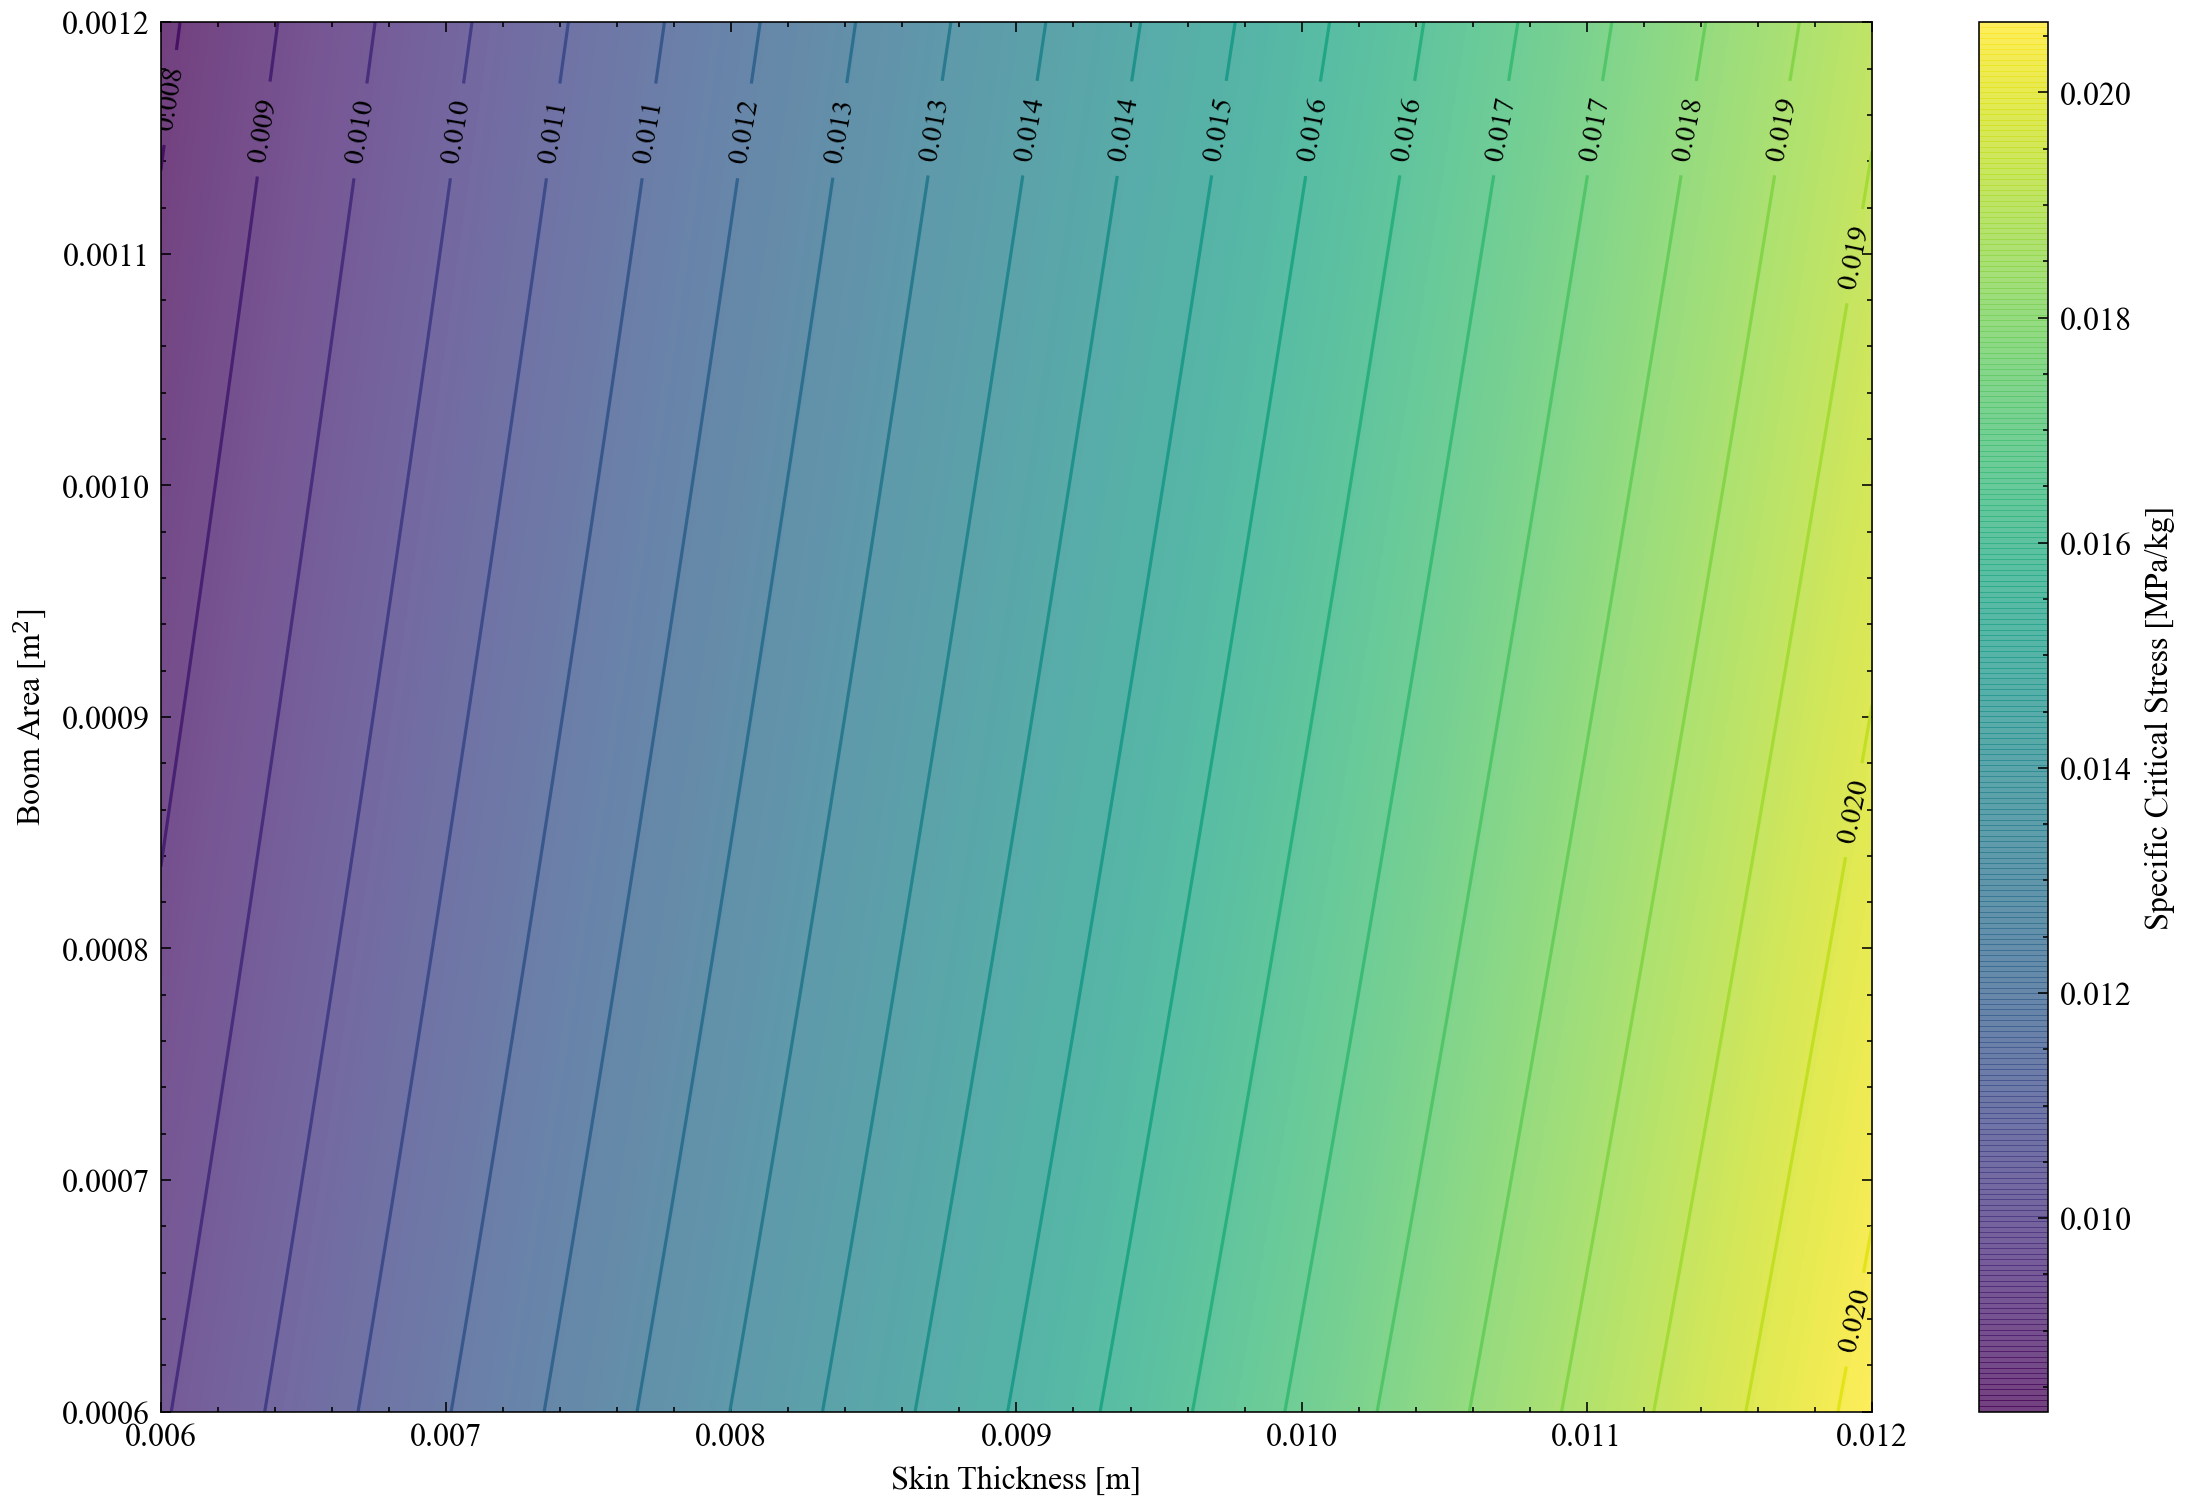

In [31]:
plt.figure(dpi=230, figsize=(12,8))
plt.style.use(['science', 'no-latex'])

specific_strength = critical_stresses/box_masses

x_mesh, y_mesh = np.meshgrid(skin_thickness_vec, stringer_area_vec)

contours = plt.contour(x_mesh, y_mesh, specific_strength, 20)

plt.clabel(contours, inline=True, fontsize=9, colors='black')

plt.imshow(
    specific_strength,
    extent = [thickness_lims[0], thickness_lims[1], area_lims[0], area_lims[1]], 
    origin='lower', 
    alpha=0.75, 
    aspect='auto'
)

plt.ylabel(r'Boom Area [m$^2$]')
plt.xlabel(r'Skin Thickness [m]')

plt.colorbar(label='Specific Critical Stress [MPa/kg]')

plt.show()

### Iteration 2

In [32]:
# from above graphs
stringer_area = 0.0007
skin_thickness = 0.0086

box_length = 3.5
box_height = 1

num_booms = 16
stringer_space = box_length / (num_booms/2)

boom_list = np.zeros(num_booms)
num_big = 4
num_small = num_booms - num_big
num_small_row = num_small / 2

boom_list[0] = stringer_area + (stringer_space * skin_thickness / 6) + 3*(stringer_space * skin_thickness / 6)
boom_list[int(num_small_row+1)] = boom_list[int(num_small_row+2)] = boom_list[-1] = boom_list[0]

boom_list[1] = stringer_area + 6*(stringer_space * skin_thickness / 6)
boom_list[2:int(num_small_row+1)] = boom_list[int(num_small_row+3):-1]  = boom_list[1]

Ixx = num_big*boom_list[0]*0.25 + num_small*boom_list[1]*0.25

bending_stress = 0.5 * root_bending_moment / Ixx

youngs_mod = 84.95e9
poisson_ratio = 0.30
ab_ratio = 1 / stringer_space
kc = buckling_interp(ab_ratio)

critical_stress = ((kc * np.power(np.pi, 2) * youngs_mod)/(12*(1 - np.power(poisson_ratio, 2)))) * np.power(skin_thickness/stringer_space, 2)

print('Bending stress: ', np.round(bending_stress/1e6, decimals=4), ' MPa')
print('Critical stress: ', np.round(critical_stress/1e6, decimals=4), ' MPa')
print('Bending stress less than critical stress?', bending_stress < critical_stress)

Bending stress:  225.0308  MPa
Critical stress:  232.925  MPa
Bending stress less than critical stress? True


In [33]:
stringer_space, boom_list[0], boom_list[1], Ixx

(0.4375, 0.0032083333333333334, 0.0044625, 0.016595833333333334)

## Stiffener Sizing

In [34]:
ta = 0.7*skin_thickness
ba = 9*ta
bw = 20*ta
bf = 7*ta

ta*1e3, ba*1e3, bw*1e3, bf*1e3, stringer_space*1e3

(6.02, 54.17999999999999, 120.39999999999998, 42.13999999999999, 437.5)

In [35]:
# area from model = 1594.554mm^2
model_area = 1594.554 / 1e6
design_mass = box_mass([model_area], [skin_thickness])
print('Wing box mass: ', np.round(design_mass[0][0], decimals=4), ' kg')

Wing box mass:  192.4471  kg


## Lift Distribution

In [36]:
num_points = 500
span = (wing_span - fuselage_diameter)/2

y_vec = np.linspace(0, span, num=num_points)
b = wing_span - fuselage_diameter

rect_dist = ((4*(phaa_load*1.5)) / (np.pi*b)) * np.sqrt(1 - np.power(2*y_vec / b, 2))
elli_dist = (2*(phaa_load*1.5)/((1 + wing_taper_ratio)*b)) * (1 + (2*y_vec/b)*(wing_taper_ratio - 1))

schrenk_dist = (rect_dist + elli_dist)/2

schrenk_interp = interpolate.UnivariateSpline(y_vec, schrenk_dist)
schrenk_lift = np.array([integrate.quad(schrenk_interp, 0, y)[0] for y in y_vec])

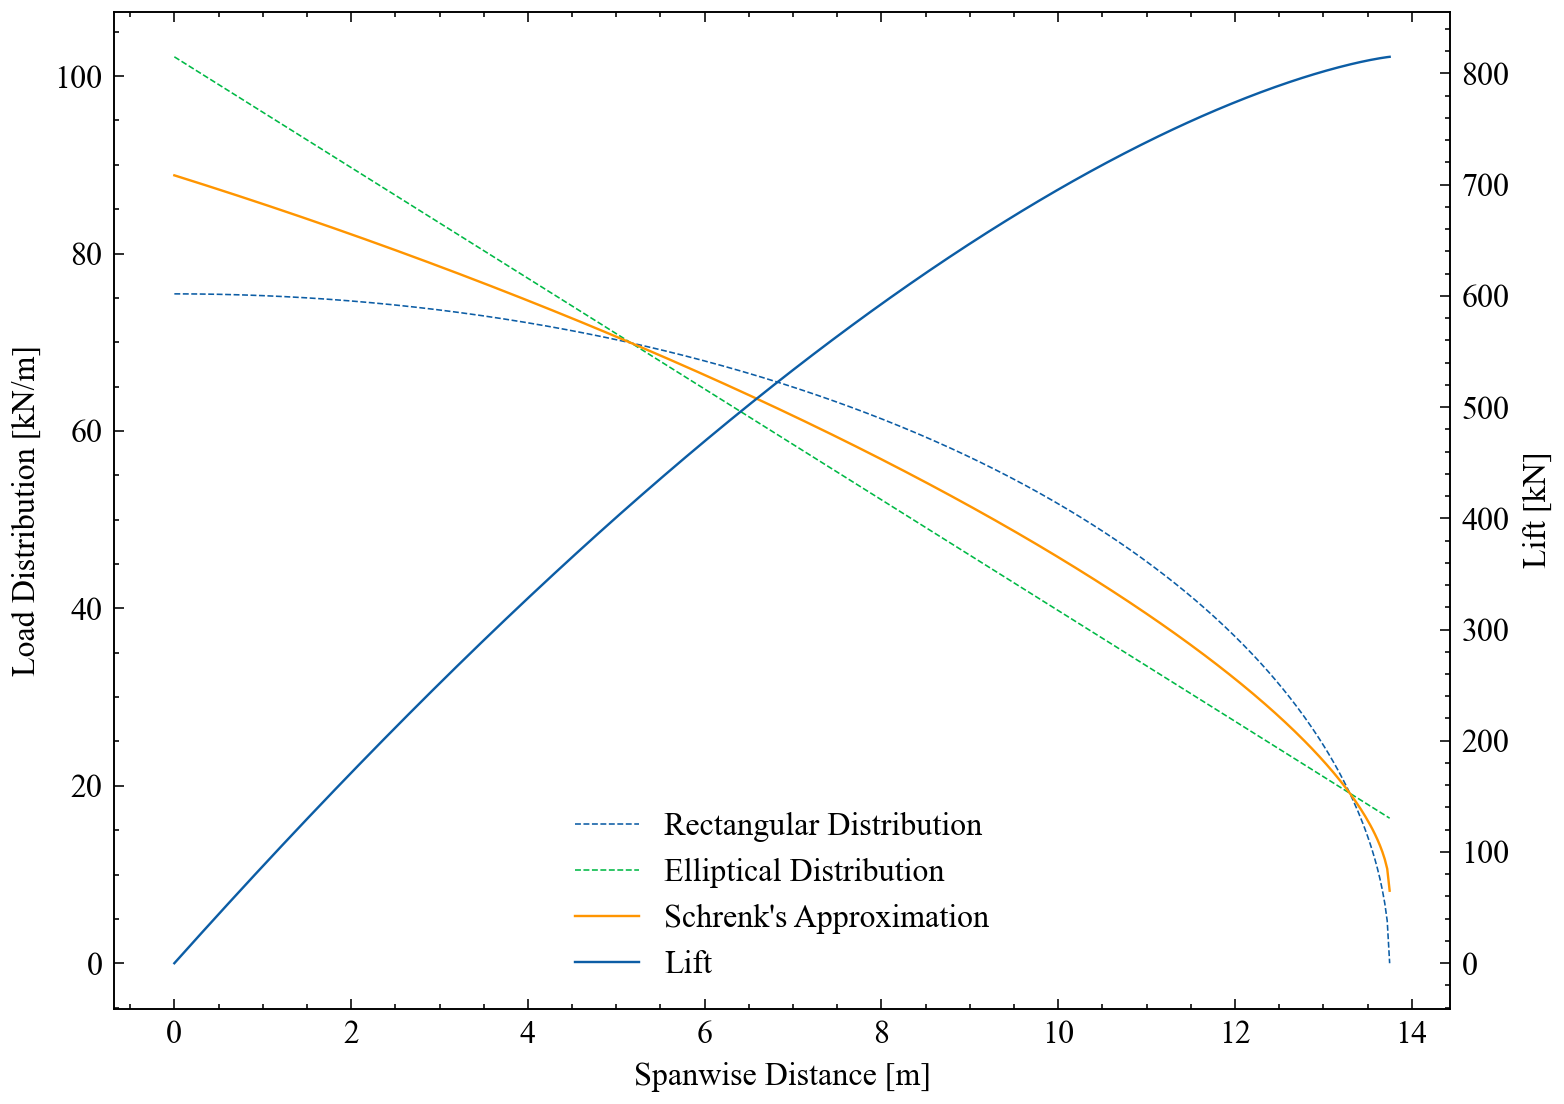

In [37]:
plt.style.use(['science', 'no-latex'])

fig, ax1 = plt.subplots(dpi=230, figsize=(7,5))
ax1.set_xlabel('Spanwise Distance [m]')
ax1.set_ylabel('Load Distribution [kN/m]')
line1 = ax1.plot(y_vec, rect_dist/1e3, linestyle='--', label='Rectangular Distribution', linewidth=0.5)
line2 = ax1.plot(y_vec, elli_dist/1e3, linestyle='--', label='Elliptical Distribution', linewidth=0.5)
line3 = ax1.plot(y_vec, schrenk_dist/1e3, label='Schrenk\'s Approximation', linewidth=0.75)

ax2 = ax1.twinx()
ax2.set_ylabel('Lift [kN]')
line4 = ax2.plot(y_vec, schrenk_lift/1e3, label='Lift', linewidth=0.75)

lines = line1 + line2 + line3 + line4
labs = [line.get_label() for line in lines]
ax1.legend(lines, labs, loc='lower center')

fig.tight_layout()
plt.show()

In [38]:
yt = 13.75/num_points

wing_box_mass = design_mass[0][0]

# assuming rectangular distributions
fuel_dist = np.zeros(num_points) 
fuel_dist[0:round(12/yt)] = 9.81*6400/round(12/yt)

structural_dist = np.ones(num_points) * (9.81*(4000 + wing_box_mass)/num_points)

lg_dist = np.zeros(num_points)
lg_dist[round(2 / yt)] = 9.81*960

engine_dist = np.zeros(num_points)
engine_dist[round(5 / yt)] = 9.81*1760

weight_dist = fuel_dist + structural_dist + lg_dist + engine_dist

net_dist = schrenk_dist - weight_dist

net_interp = interpolate.UnivariateSpline(y_vec, net_dist)
net_load = np.array([integrate.quad(net_interp, 0, y)[0] for y in y_vec])

<ipython-input-38-3889bafc57a3>:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  net_load = np.array([integrate.quad(net_interp, 0, y)[0] for y in y_vec])


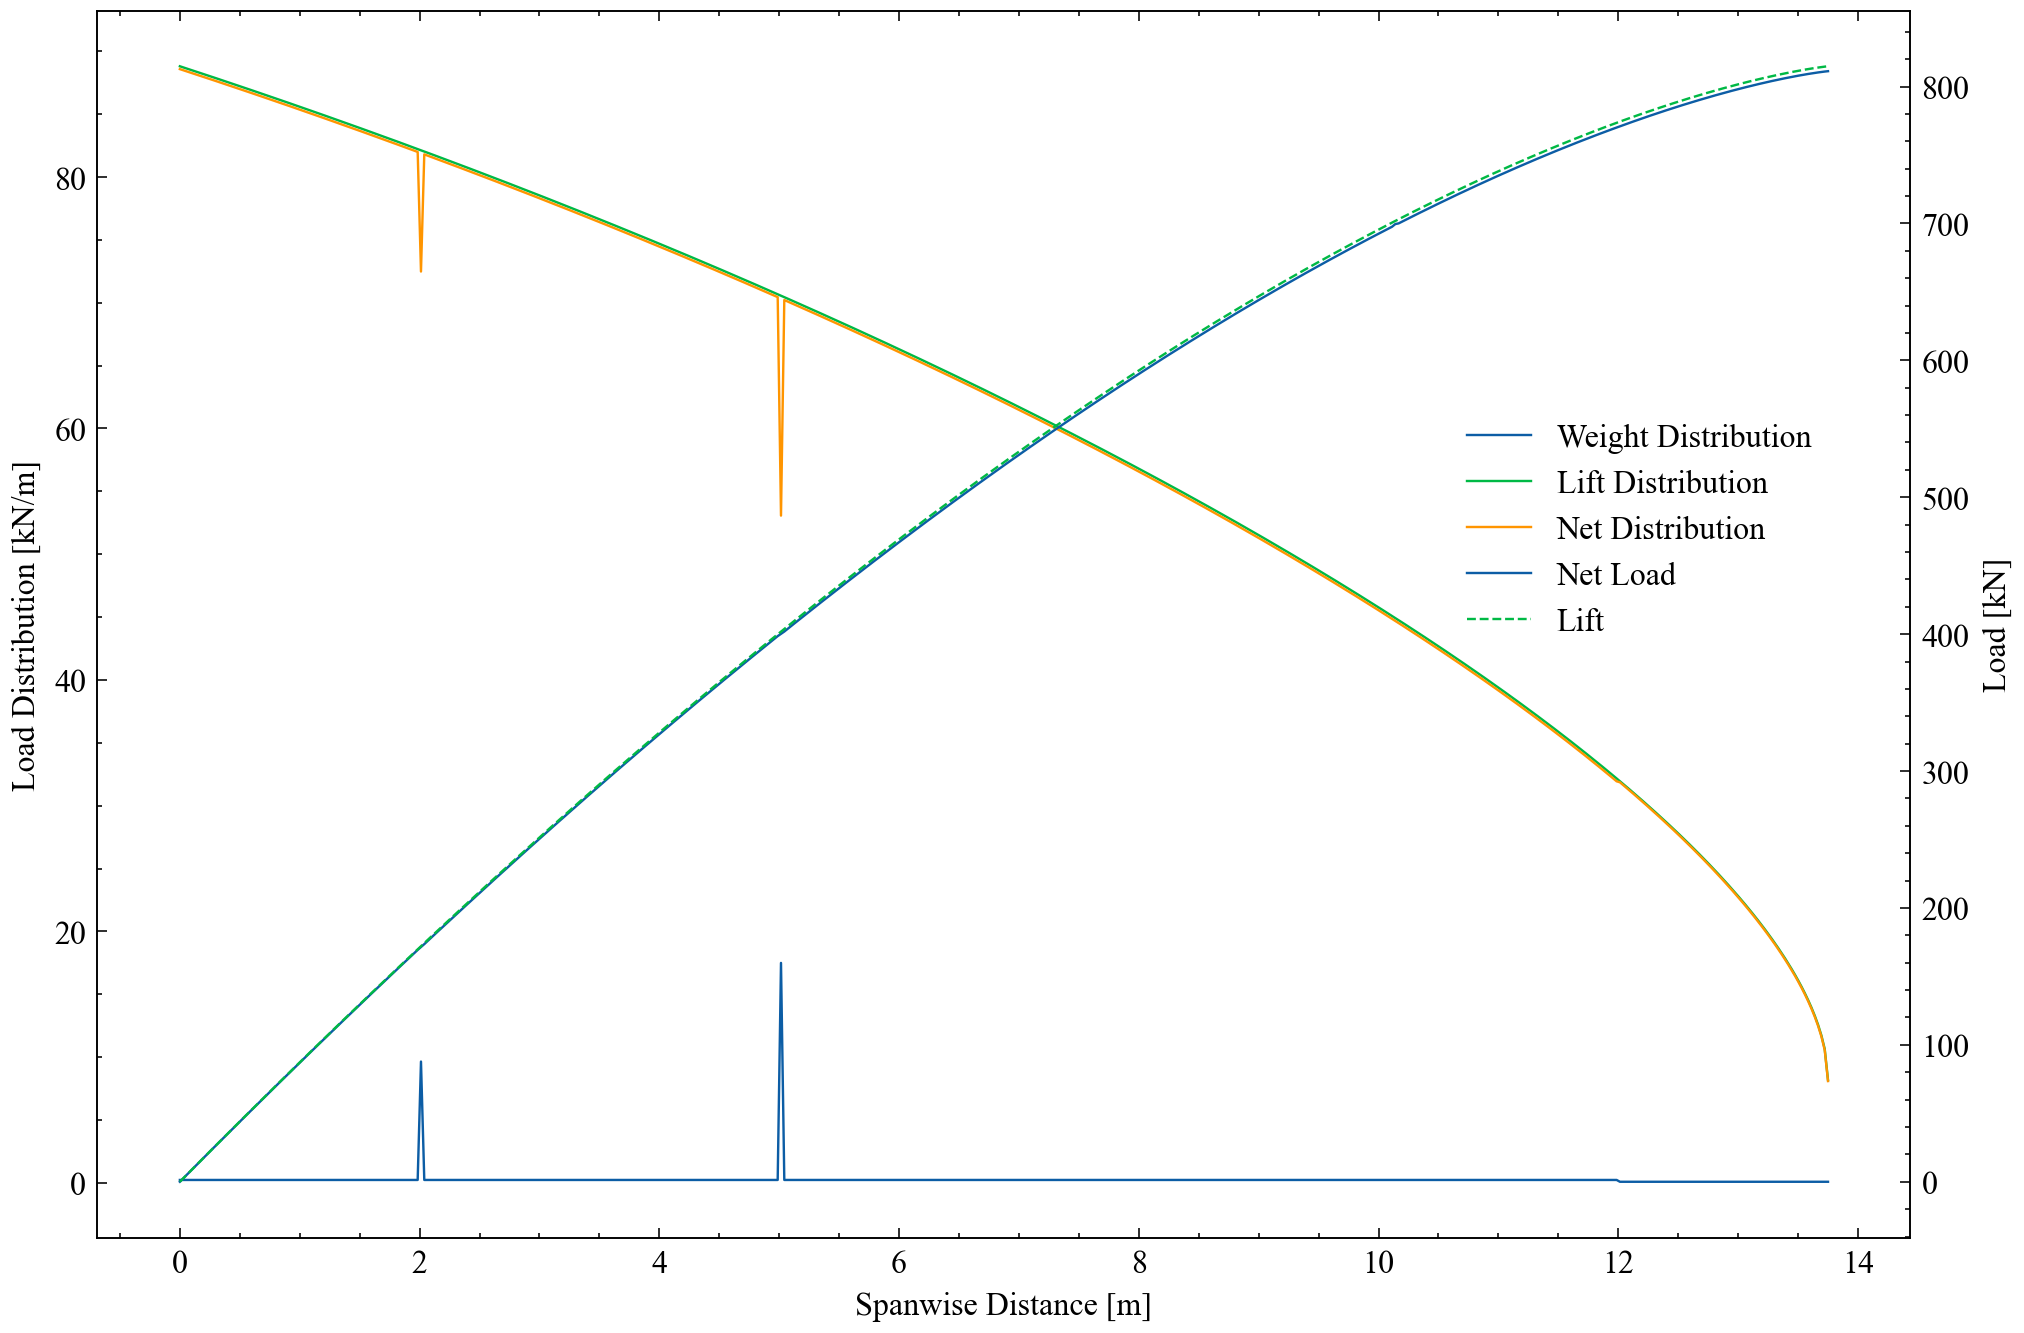

In [39]:
plt.style.use(['science', 'no-latex'])

fig, ax1 = plt.subplots(dpi=230, figsize=(9,6))
ax1.set_xlabel('Spanwise Distance [m]')
ax1.set_ylabel('Load Distribution [kN/m]')
line1 = ax1.plot(y_vec, weight_dist/1e3, label='Weight Distribution', linewidth=0.75)
line2 = ax1.plot(y_vec, schrenk_dist/1e3, label='Lift Distribution', linewidth=0.75)
line3 = ax1.plot(y_vec, net_dist/1e3, label='Net Distribution', linewidth=0.75)

ax2 = ax1.twinx()
ax2.set_ylabel('Load [kN]')
line4 = ax2.plot(y_vec, net_load/1e3, label='Net Load', linewidth=0.75)
line5 = ax2.plot(y_vec, schrenk_lift/1e3, label='Lift', linestyle='--', linewidth=0.75)

lines = line1 + line2 + line3 + line4 + line5
labs = [line.get_label() for line in lines]
ax1.legend(lines, labs, bbox_to_anchor=(0.9,0.5), loc="lower right",  bbox_transform=fig.transFigure)

fig.tight_layout()
plt.show()